<a href="https://colab.research.google.com/github/AvulaBhumika/Handwritten-Digit-Classification-using-MNIST/blob/main/Hand_written_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hand written text classification

In [2]:
import subprocess

try:
    import google.colab
    subprocess.run(['python', '-m', 'pip', 'install', 'skorch' , 'torch'])
except ImportError:
    pass

In [3]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

## Loading Data
Using SciKit-Learns ```fetch_openml``` to load MNIST data.

In [4]:
mnist = fetch_openml('mnist_784', as_frame=False, cache=False)

In [5]:
mnist.data.shape

(70000, 784)

## Preprocessing Data

Each image of the MNIST dataset is encoded in a 784 dimensional vector, representing a 28 x 28 pixel image. Each pixel has a value between 0 and 255, corresponding to the grey-value of a pixel.<br />
The above ```featch_mldata``` method to load MNIST returns ```data``` and ```target``` as ```uint8``` which we convert to ```float32``` and ```int64``` respectively.

In [6]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

In [7]:
X /= 255.0

In [8]:
X.min(), X.max()

(np.float32(0.0), np.float32(1.0))

Note: data is not normalized.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [10]:
assert(X_train.shape[0] + X_test.shape[0] == mnist.data.shape[0])

In [11]:
X_train.shape, y_train.shape

((52500, 784), (52500,))

### Print a selection of training images and their labels

In [12]:
def plot_example(X, y):
    """Plot the first 100 images in a 10x10 grid."""
    plt.figure(figsize=(15, 15))  # Set figure size to be larger (you can adjust as needed)

    for i in range(10):  # For 10 rows
        for j in range(10):  # For 10 columns
            index = i * 10 + j
            plt.subplot(10, 10, index + 1)  # 10 rows, 10 columns, current index
            plt.imshow(X[index].reshape(28, 28))  # Display the image
            plt.xticks([])  # Remove x-ticks
            plt.yticks([])  # Remove y-ticks
            plt.title(y[index], fontsize=8)  # Display the label as title with reduced font size

    plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust spacing (you can modify as needed)
    plt.tight_layout()  # Adjust the spacing between plots for better visualization
    plt.show()  # Display the entire grid


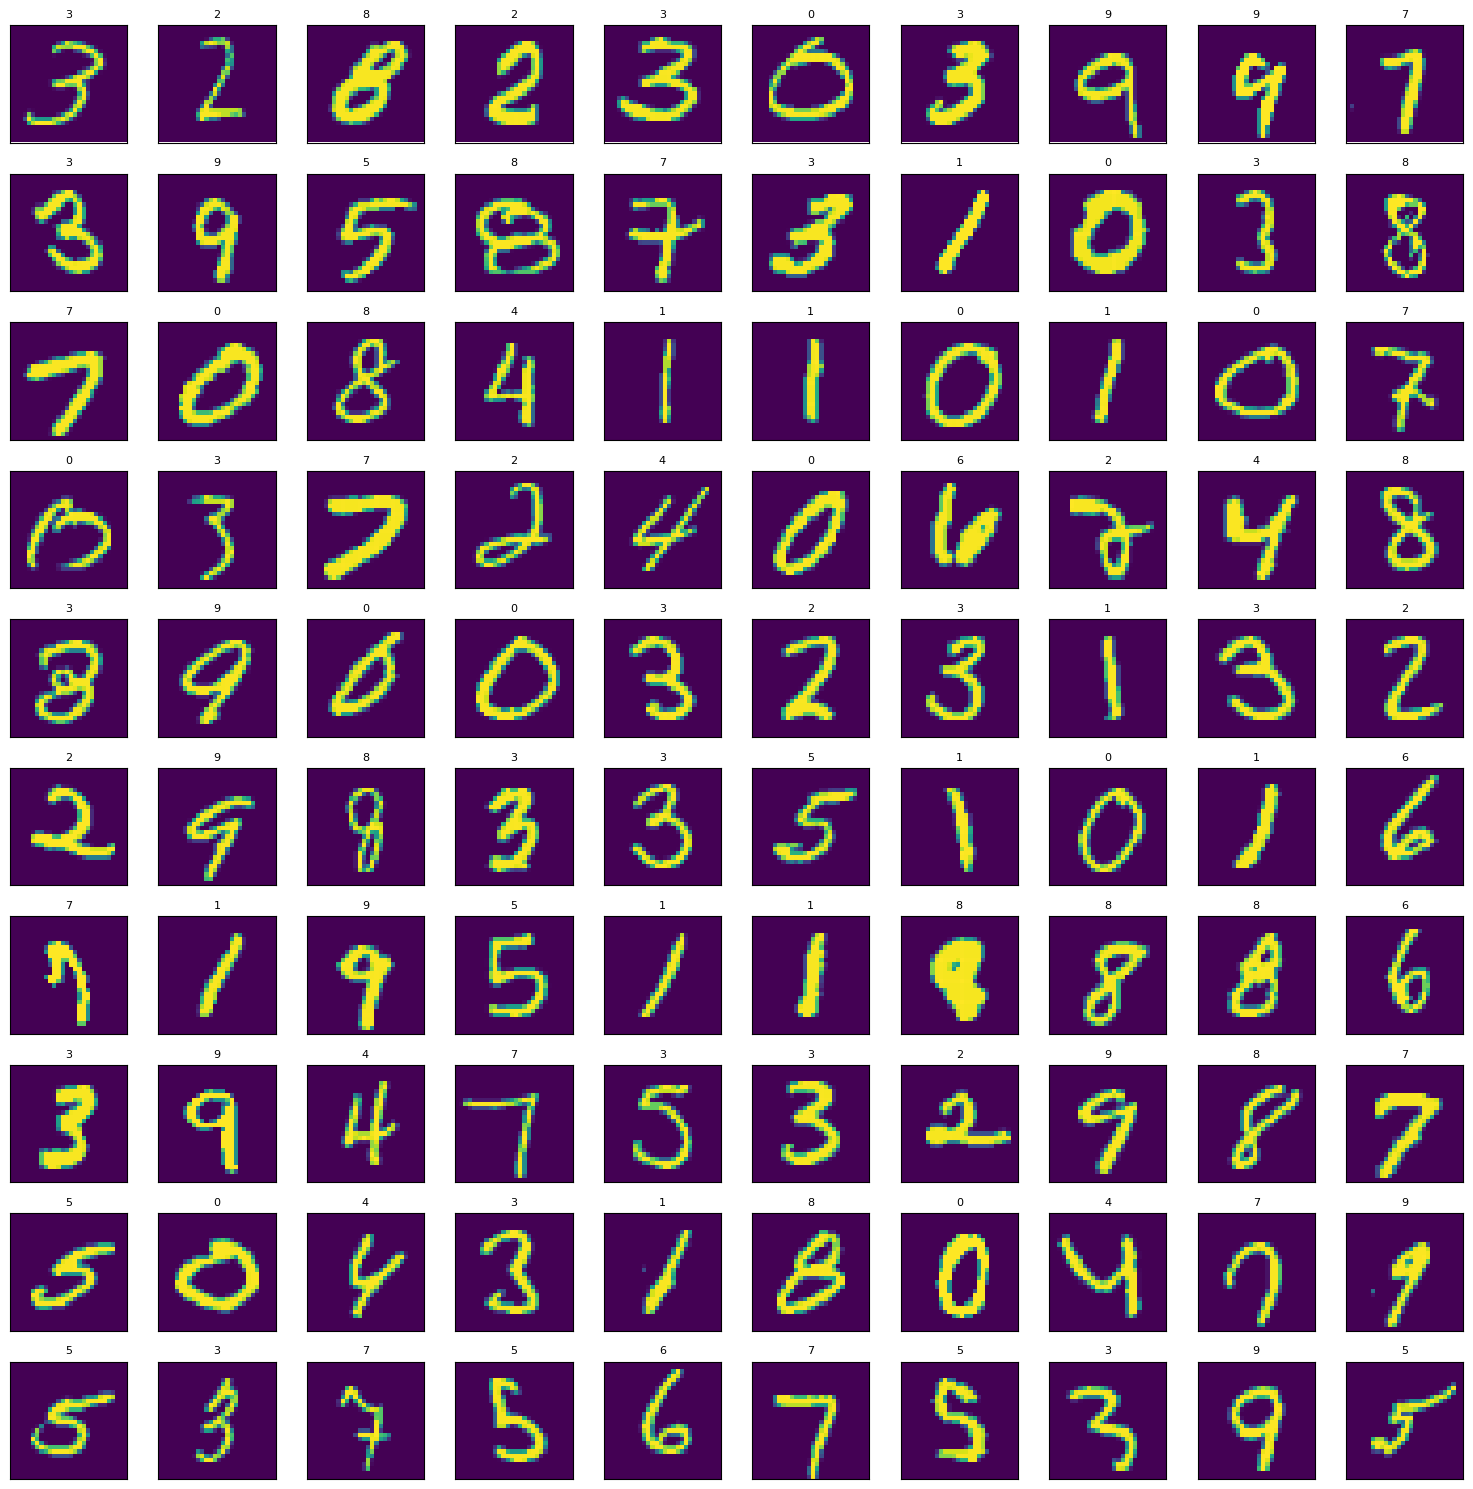

In [13]:
plot_example(X_train, y_train)

## Build Neural Network with PyTorch
Simple, fully connected neural network with one hidden layer. Input layer has 784 dimensions (28x28), hidden layer has 98 (= 784 / 8) and output layer 10 neurons, representing digits 0 - 9.

In [14]:
import torch
from torch import nn
import torch.nn.functional as F

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [16]:
device

'cuda'

In [17]:
mnist_dim = X.shape[1]
hidden_dim = int(mnist_dim/8)
output_dim = len(np.unique(mnist.target))

In [18]:
mnist_dim, hidden_dim, output_dim

(784, 98, 10)

A Neural network in PyTorch's framework.

In [19]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim=mnist_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.dropout = nn.Dropout(dropout)

        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, X, **kwargs):
        X = F.relu(self.hidden(X))
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=-1)
        return X

skorch allows to use PyTorch's networks in the SciKit-Learn setting:

In [20]:
from skorch import NeuralNetClassifier

In [21]:
torch.manual_seed(0)

net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=20,
    lr=0.1,
    device=device,
)

In [22]:
net.fit(X_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8387       0.8800        0.4174  1.4439
      2        0.4332       0.9103        0.3133  0.9018
      3        0.3612       0.9233        0.2684  0.9005
      4        0.3233       0.9309        0.2317  0.8606
      5        0.2938       0.9353        0.2173  1.1654
      6        0.2738       0.9390        0.2039  1.1229
      7        0.2600       0.9454        0.1868  0.8977
      8        0.2427       0.9484        0.1757  0.9007
      9        0.2362       0.9503        0.1683  0.8983
     10        0.2226       0.9512        0.1621  0.8834
     11        0.2184       0.9529        0.1565  0.8957
     12        0.2090       0.9541        0.1508  0.8797
     13        0.2067       0.9570        0.1446  0.8718
     14        0.1978       0.9570        0.1412  0.8749
     15        0.1923       0.9582        0.1392  0.9046
     16        0.1889       0.9

## Prediction

In [23]:
from sklearn.metrics import accuracy_score

In [24]:
y_pred = net.predict(X_test)

In [25]:
accuracy_score(y_test, y_pred)

0.9631428571428572

An accuracy of about 96% for a network with only one hidden layer is not too bad.

 predictions that went wrong:

In [26]:
error_mask = y_pred != y_test

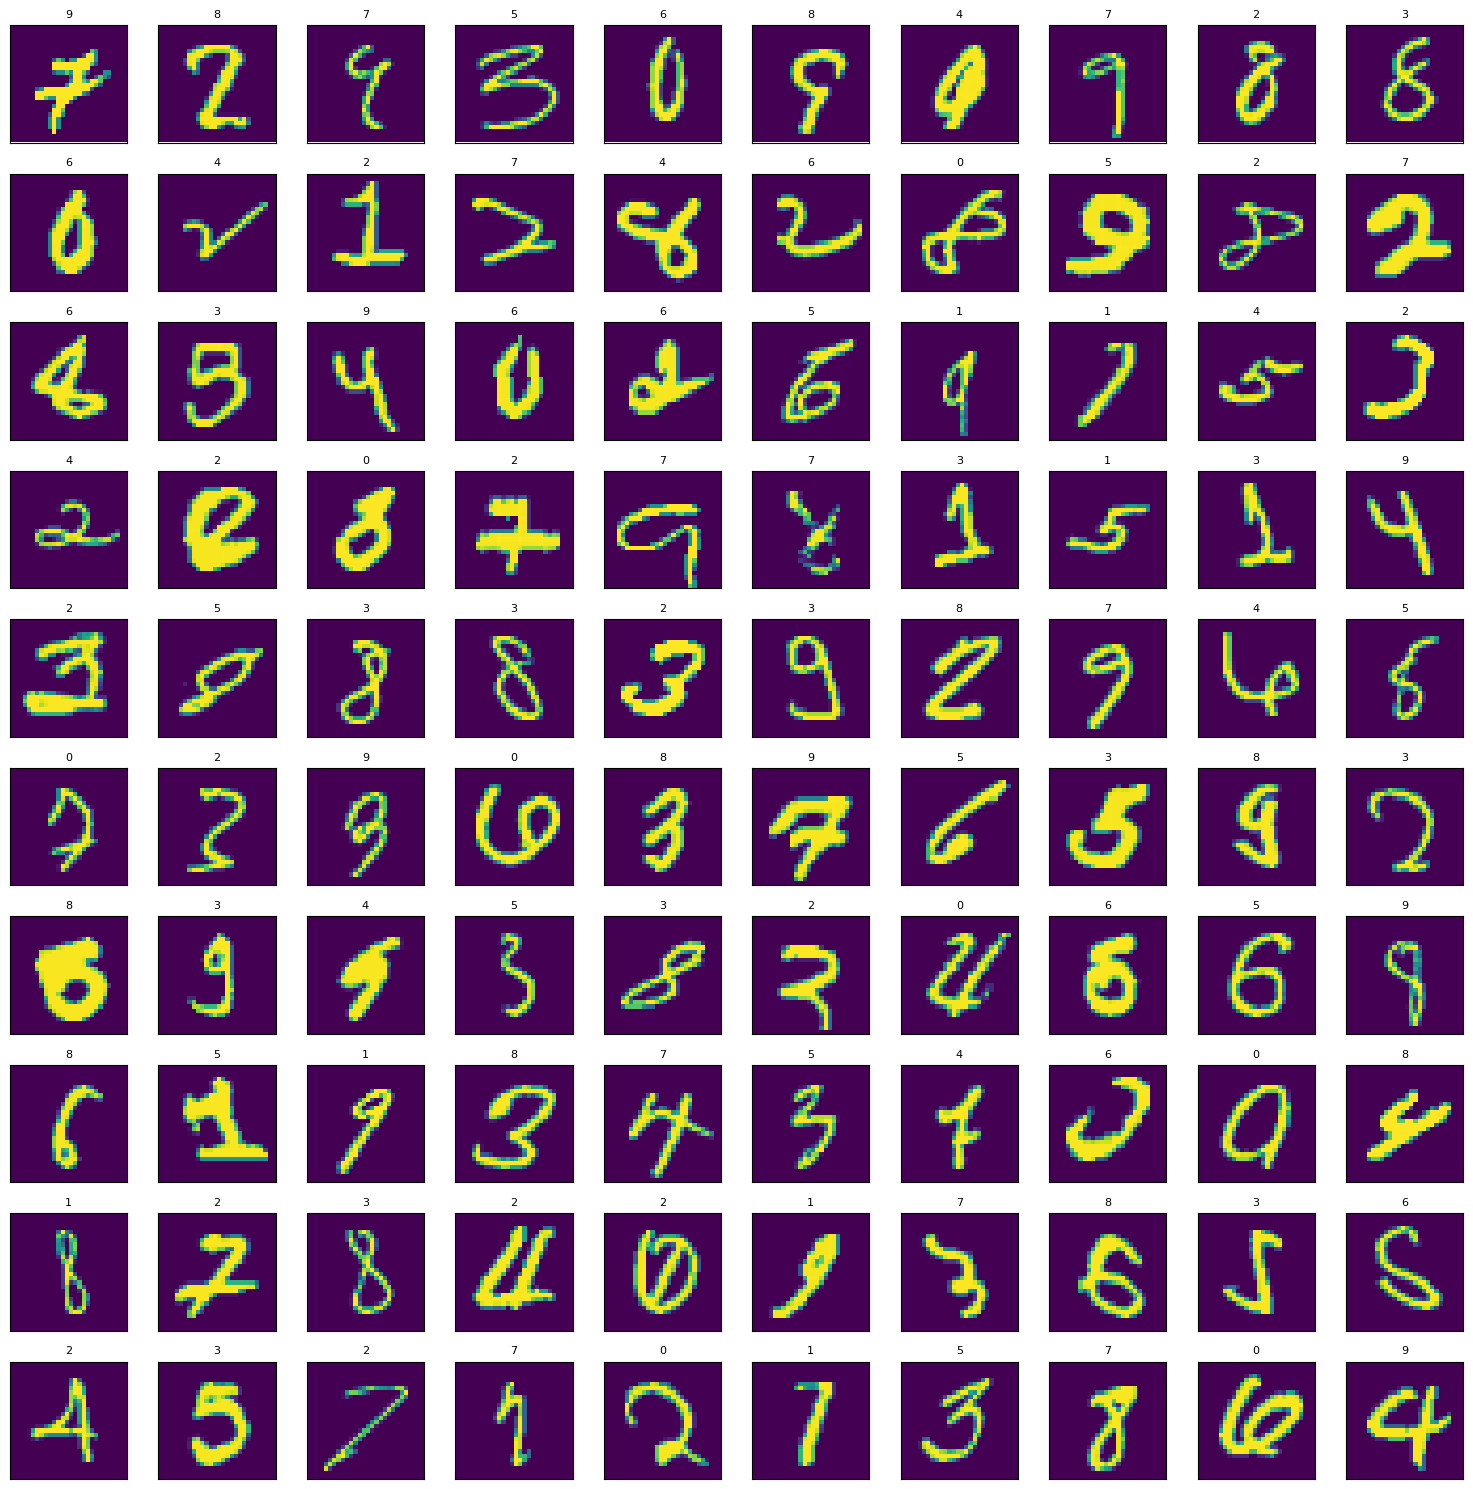

In [27]:
plot_example(X_test[error_mask], y_pred[error_mask])



```
# This is formatted as code
```

# Convolutional Network
PyTorch expects a 4 dimensional tensor as input for its 2D convolution layer. The dimensions represent:
* Batch size
* Number of channel
* Height
* Width

As initial batch size the number of examples needs to be provided. MNIST data has only one channel. As stated above, each MNIST vector represents a 28x28 pixel image. Hence, the resulting shape for PyTorch tensor needs to be (x, 1, 28, 28).

In [28]:
XCnn = X.reshape(-1, 1, 28, 28)

In [29]:
XCnn.shape

(70000, 1, 28, 28)

In [30]:
XCnn_train, XCnn_test, y_train, y_test = train_test_split(XCnn, y, test_size=0.25, random_state=42)

In [31]:
XCnn_train.shape, y_train.shape

((52500, 1, 28, 28), (52500,))

In [32]:
class Cnn(nn.Module):
    def __init__(self, dropout=0.5):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(1600, 100) # 1600 = number channels * width * height
        self.fc2 = nn.Linear(100, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x):
        x = torch.relu(F.max_pool2d(self.conv1(x), 2))
        x = torch.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))

        # flatten over channel, height and width = 1600
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))

        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

In [33]:
torch.manual_seed(0)

cnn = NeuralNetClassifier(
    Cnn,
    max_epochs=10,
    lr=0.002,
    optimizer=torch.optim.Adam,
    device=device,
)

In [34]:
cnn.fit(XCnn_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4320       0.9706        0.0911  1.8445
      2        0.1636       0.9806        0.0637  1.4802
      3        0.1354       0.9816        0.0574  1.7533
      4        0.1146       0.9849        0.0490  1.4102
      5        0.1032       0.9858        0.0460  1.4028
      6        0.0971       0.9874        0.0429  1.4178
      7        0.0856       0.9871        0.0406  1.4145
      8        0.0854       0.9872        0.0409  1.4138
      9        0.0827       0.9876        0.0404  1.4189
     10        0.0753       0.9888        0.0369  1.4897


In [35]:
y_pred_cnn = cnn.predict(XCnn_test)

In [36]:
accuracy_score(y_test, y_pred_cnn)

0.9875428571428572

An accuracy of >98% should suffice for this example!

Let's see how we fare on the examples that went wrong before:

In [37]:
accuracy_score(y_test[error_mask], y_pred_cnn[error_mask])

0.7565891472868217

Over 70% of the previously misclassified images are now correctly identified.

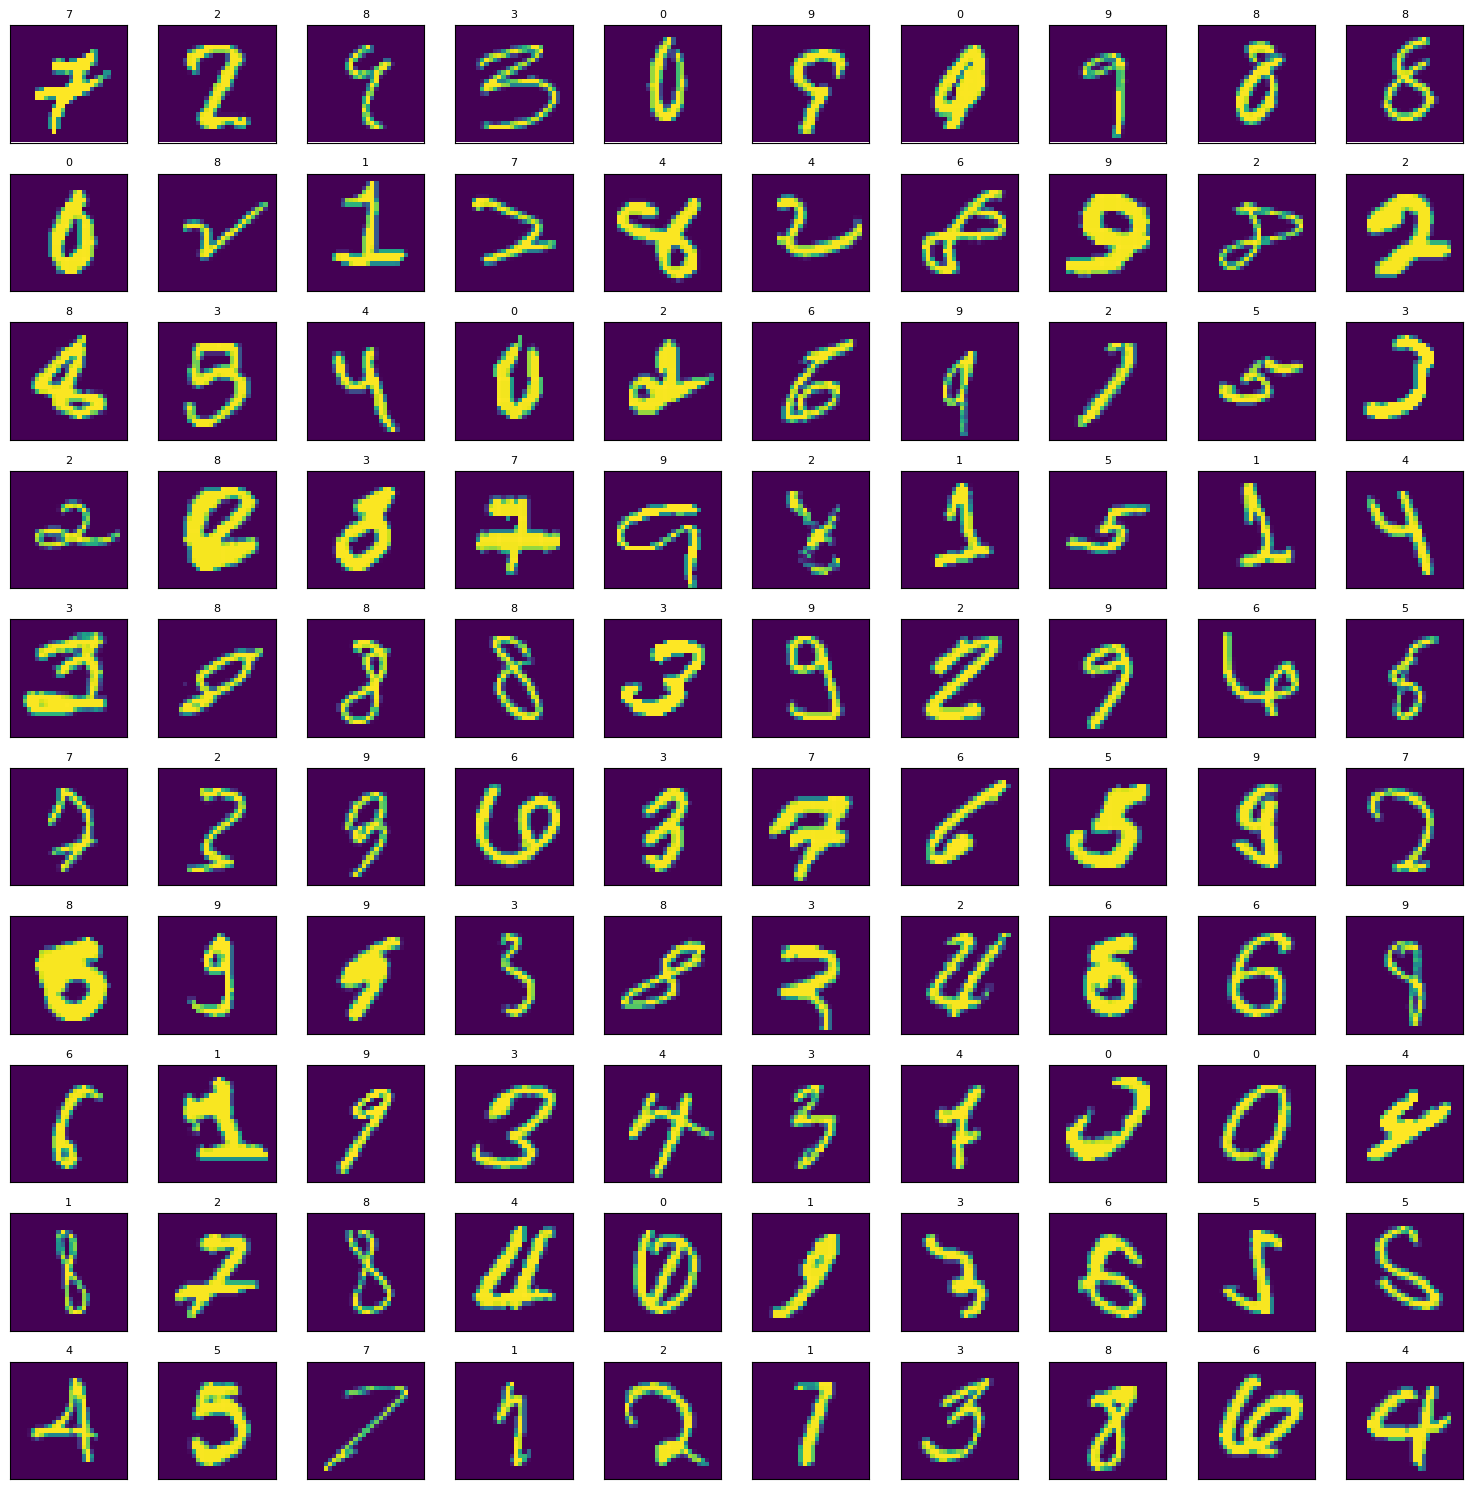

In [38]:
plot_example(X_test[error_mask], y_pred_cnn[error_mask])